In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import tqdm
import sklearn.utils
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from psutil import virtual_memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 16 22:03:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
def load_pubmed_sentences(file_path):
    sentences = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                label, sentence = line.split('\t', 1)
                labels.append(label)
                sentences.append(sentence)
            except ValueError:
                continue
    return sentences, labels


In [ ]:
train_sents, train_labs = load_pubmed_sentences('/content/drive/MyDrive/PubMed/pubmed-rct-master/PubMed_20k_RCT/train.txt')
dev_sents, dev_labs = load_pubmed_sentences('/content/drive/MyDrive/PubMed/pubmed-rct-master/PubMed_20k_RCT/dev.txt')
test_sents, test_labs = load_pubmed_sentences('/content/drive/MyDrive/PubMed/pubmed-rct-master/PubMed_20k_RCT/test.txt')

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labs)

dev_labels_encoded = label_encoder.transform(dev_labs)
test_labels_encoded = label_encoder.transform(test_labs)

df_train = pd.DataFrame({'text': train_sents, 'label': train_labels_encoded})
df_dev = pd.DataFrame({'text': dev_sents, 'label': dev_labels_encoded})
df_test = pd.DataFrame({'text': test_sents, 'label': test_labels_encoded})

In [ ]:
print("Classes:", label_encoder.classes_)
print("Train size:", len(df_train))
print("Validation size:", len(df_dev))
print("Test size:", len(df_test))


Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']
Train size: 180040
Validation size: 30212
Test size: 30135


Labels  [0 1 2 3 4]
Label counts  [21727 27168 59353 13839 57953]


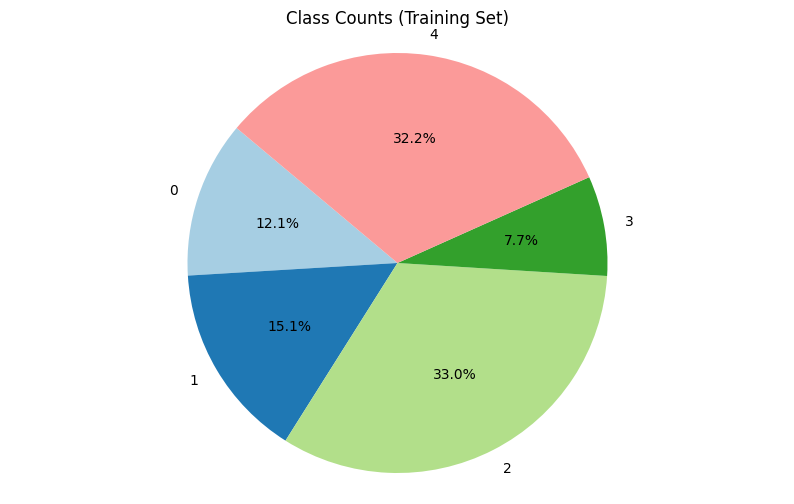

The label 0 has 21727 records in the training dataset.
The label 1 has 27168 records in the training dataset.
The label 2 has 59353 records in the training dataset.
The label 3 has 13839 records in the training dataset.
The label 4 has 57953 records in the training dataset.


In [ ]:
lbls = df_train['label'].values

labels = np.unique(lbls)
labelCounts = np.unique(lbls, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

plt.figure(figsize=(10, 6))
plt.title("Class Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the training dataset.")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def encode_dataset(df, tokenizer, max_length=128):
    inputs = tokenizer(
        df['text'].tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    labels = torch.tensor(df['label'].values)
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [ ]:
train_dataset = encode_dataset(df_train, tokenizer)
val_dataset = encode_dataset(df_dev, tokenizer)
test_dataset = encode_dataset(df_test, tokenizer)

# Dataloaders
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)


In [ ]:
def train_model(model, train_loader, val_loader, save_path, epochs=20,
                learning_rates=[2e-5, 5e-6, 1e-6, 2e-6], patience=7):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_f1 = 0

    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")
        optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        patience_counter = 0

        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, labels = batch

                model.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                total_loss += loss.item()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch + 1} Train Loss: {avg_train_loss:.4f}")

            # ----- Validation -----
            model.eval()
            preds, true = [], []
            with torch.no_grad():
                for batch in val_loader:
                    batch = tuple(t.to(device) for t in batch)
                    input_ids, input_mask, labels = batch
                    outputs = model(input_ids=input_ids, attention_mask=input_mask)
                    logits = outputs.logits
                    batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
                    preds.extend(batch_preds)
                    true.extend(labels.cpu().numpy())

            f1 = f1_score(true, preds, average='micro')
            print(f"Epoch {epoch + 1}, Validation Micro F1: {f1:.4f}")

            if f1 > best_val_f1:
                best_val_f1 = f1
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
                print("Best model saved.")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_encoder.classes_)
)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    save_path="best_bert_pubmed.pt",
    epochs=20,
    learning_rates=[2e-5, 5e-6, 1e-6, 2e-6],
    patience=7
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with learning rate: 2e-05


Epoch 1/20: 100%|██████████| 5627/5627 [14:09<00:00,  6.62batch/s]


Epoch 1 Train Loss: 0.5921
Epoch 1, Validation Micro F1: 0.8676
Best model saved.


Epoch 2/20: 100%|██████████| 5627/5627 [14:09<00:00,  6.62batch/s]


Epoch 2 Train Loss: 0.3652
Epoch 2, Validation Micro F1: 0.8716
Best model saved.


Epoch 3/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.62batch/s]


Epoch 3 Train Loss: 0.3181
Epoch 3, Validation Micro F1: 0.8719
Best model saved.


Epoch 4/20: 100%|██████████| 5627/5627 [14:09<00:00,  6.62batch/s]


Epoch 4 Train Loss: 0.2568
Epoch 4, Validation Micro F1: 0.8670
No improvement. Patience: 1/7


Epoch 5/20: 100%|██████████| 5627/5627 [14:08<00:00,  6.63batch/s]


Epoch 5 Train Loss: 0.2022
Epoch 5, Validation Micro F1: 0.8676
No improvement. Patience: 2/7


Epoch 6/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.61batch/s]


Epoch 6 Train Loss: 0.1571
Epoch 6, Validation Micro F1: 0.8678
No improvement. Patience: 3/7


Epoch 7/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.62batch/s]


Epoch 7 Train Loss: 0.1202
Epoch 7, Validation Micro F1: 0.8646
No improvement. Patience: 4/7


Epoch 8/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.62batch/s]


Epoch 8 Train Loss: 0.0920
Epoch 8, Validation Micro F1: 0.8557
No improvement. Patience: 5/7


Epoch 9/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.62batch/s]


Epoch 9 Train Loss: 0.0724
Epoch 9, Validation Micro F1: 0.8594
No improvement. Patience: 6/7


Epoch 10/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.62batch/s]


Epoch 10 Train Loss: 0.0561
Epoch 10, Validation Micro F1: 0.8624
No improvement. Patience: 7/7
Early stopping triggered.

Training with learning rate: 5e-06


Epoch 1/20: 100%|██████████| 5627/5627 [14:11<00:00,  6.61batch/s]


Epoch 1 Train Loss: 0.0287
Epoch 1, Validation Micro F1: 0.8626
No improvement. Patience: 1/7


Epoch 2/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.61batch/s]


Epoch 2 Train Loss: 0.0249
Epoch 2, Validation Micro F1: 0.8601
No improvement. Patience: 2/7


Epoch 3/20: 100%|██████████| 5627/5627 [14:11<00:00,  6.61batch/s]


Epoch 3 Train Loss: 0.0223
Epoch 3, Validation Micro F1: 0.8634
No improvement. Patience: 3/7


Epoch 4/20: 100%|██████████| 5627/5627 [14:11<00:00,  6.61batch/s]


Epoch 4 Train Loss: 0.0196
Epoch 4, Validation Micro F1: 0.8623
No improvement. Patience: 4/7


Epoch 5/20: 100%|██████████| 5627/5627 [14:11<00:00,  6.61batch/s]


Epoch 5 Train Loss: 0.0163
Epoch 5, Validation Micro F1: 0.8645
No improvement. Patience: 5/7


Epoch 6/20: 100%|██████████| 5627/5627 [14:11<00:00,  6.61batch/s]


Epoch 6 Train Loss: 0.0137
Epoch 6, Validation Micro F1: 0.8656
No improvement. Patience: 6/7


Epoch 7/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.61batch/s]


Epoch 7 Train Loss: 0.0128
Epoch 7, Validation Micro F1: 0.8635
No improvement. Patience: 7/7
Early stopping triggered.

Training with learning rate: 1e-06


Epoch 1/20: 100%|██████████| 5627/5627 [14:11<00:00,  6.61batch/s]


Epoch 1 Train Loss: 0.0088
Epoch 1, Validation Micro F1: 0.8660
No improvement. Patience: 1/7


Epoch 2/20: 100%|██████████| 5627/5627 [14:11<00:00,  6.61batch/s]


Epoch 2 Train Loss: 0.0082
Epoch 2, Validation Micro F1: 0.8664
No improvement. Patience: 2/7


Epoch 3/20: 100%|██████████| 5627/5627 [14:11<00:00,  6.61batch/s]


Epoch 3 Train Loss: 0.0067
Epoch 3, Validation Micro F1: 0.8659
No improvement. Patience: 3/7


Epoch 4/20: 100%|██████████| 5627/5627 [14:10<00:00,  6.62batch/s]


Epoch 4 Train Loss: 0.0053
Epoch 4, Validation Micro F1: 0.8657
No improvement. Patience: 4/7


Epoch 5/20: 100%|██████████| 5627/5627 [14:08<00:00,  6.63batch/s]


Epoch 5 Train Loss: 0.0050
Epoch 5, Validation Micro F1: 0.8664
No improvement. Patience: 5/7


Epoch 6/20: 100%|██████████| 5627/5627 [14:08<00:00,  6.63batch/s]


Epoch 6 Train Loss: 0.0055
Epoch 6, Validation Micro F1: 0.8666
No improvement. Patience: 6/7


Epoch 7/20: 100%|██████████| 5627/5627 [14:08<00:00,  6.63batch/s]


Epoch 7 Train Loss: 0.0048
Epoch 7, Validation Micro F1: 0.8656
No improvement. Patience: 7/7
Early stopping triggered.

Training with learning rate: 2e-06


Epoch 1/20: 100%|██████████| 5627/5627 [14:08<00:00,  6.63batch/s]


Epoch 1 Train Loss: 0.0037
Epoch 1, Validation Micro F1: 0.8637
No improvement. Patience: 1/7


Epoch 2/20: 100%|██████████| 5627/5627 [14:08<00:00,  6.63batch/s]


Epoch 2 Train Loss: 0.0054
Epoch 2, Validation Micro F1: 0.8659
No improvement. Patience: 2/7


Epoch 3/20: 100%|██████████| 5627/5627 [14:08<00:00,  6.63batch/s]


Epoch 3 Train Loss: 0.0060
Epoch 3, Validation Micro F1: 0.8676
No improvement. Patience: 3/7


Epoch 4/20: 100%|██████████| 5627/5627 [14:07<00:00,  6.64batch/s]


Epoch 4 Train Loss: 0.0053
Epoch 4, Validation Micro F1: 0.8644
No improvement. Patience: 4/7


Epoch 5/20: 100%|██████████| 5627/5627 [14:08<00:00,  6.63batch/s]


Epoch 5 Train Loss: 0.0048
Epoch 5, Validation Micro F1: 0.8653
No improvement. Patience: 5/7


Epoch 6/20: 100%|██████████| 5627/5627 [14:09<00:00,  6.62batch/s]


Epoch 6 Train Loss: 0.0047
Epoch 6, Validation Micro F1: 0.8654
No improvement. Patience: 6/7


Epoch 7/20: 100%|██████████| 5627/5627 [14:09<00:00,  6.62batch/s]


Epoch 7 Train Loss: 0.0047
Epoch 7, Validation Micro F1: 0.8664
No improvement. Patience: 7/7
Early stopping triggered.


In [ ]:
model.load_state_dict(torch.load("best_bert_pubmed.pt"))
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

test_preds = []
test_true = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_preds_labels = label_encoder.inverse_transform(test_preds)
test_true_labels = label_encoder.inverse_transform(test_true)

print("\nClassification Report on Test Set:")
print(classification_report(test_true_labels, test_preds_labels))

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/PubMed/best_bert_pubmed.pt')